# RAF-DB - all classes
**Author**: Johannes S. Fischer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime

In [2]:
model_name = 'RAF-bias'

Load pretrained model to fine-tune it? If yes, specify model name, if no set it to ```None```.

In [3]:
pretrained_model_name = None

# Data

## Preprocessing Function
Preprocessing function like for VGG16, where pixel values per channel are normalized to have zero mean (```tensorflow``` implementation can be found [here](https://github.com/keras-team/keras/blob/2c48a3b38b6b6139be2da501982fd2f61d7d48fe/keras/applications/imagenet_utils.py#L168)).

In [4]:
# RAF-DB training data mean and std
mean = [146.6770, 114.6274, 102.3102]
std = None # [67.6282, 61.7651, 61.3665]

def preprocess(x):
    # ensure image format
    x = np.array(x, dtype='float32')
    
    # normalize
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    if std is not None:
        x[..., 0] /= std[0]
        x[..., 1] /= std[1]
        x[..., 2] /= std[2] 
    return x

def de_preprocess(x):
    if std is not None:
        x[..., 0] *= std[0]
        x[..., 1] *= std[1]
        x[..., 2] *= std[2]
    # normalize
    x[..., 0] += mean[0]
    x[..., 1] += mean[1]
    x[..., 2] += mean[2]
    return x.astype('uint8')

## Load Data

In [5]:
%%time

from utils.Dataloader import load_biased_RAF_targetvector

# settings
DATA_DIR = './data/biased/'

IMG_SIZE = (100, 100)
IMG_SHAPE = IMG_SIZE + (3,)

BATCH_SIZE = 64

# load data
train_ds, val_ds, test_ds = load_biased_RAF_targetvector(DATA_DIR,
                                                  target_img_size=IMG_SIZE,
                                                  image_dir_name='asian/',  # change here
                                                  batch_size=BATCH_SIZE,
                                                  preprocessing_function=preprocess)

Splitting testing dataset into stratified validation and training set
Training
- (1912, 100, 100, 3) 
- (1912, 7)
Validation
- (242, 100, 100, 3) 
- (242, 7)
Testing
- (241, 100, 100, 3) 
- (241, 7)
CPU times: user 981 ms, sys: 705 ms, total: 1.69 s
Wall time: 2.64 s


Prepare some function to get labels...

In [6]:
emotion_labels = ['surprise', 'fear', 'disgust', 'happiness', 'sadness', 'anger', 'neutral']

num_classes = len(emotion_labels)
print("Number of classes: ", num_classes)

def vec2label(onehot_vec):
    major_vote = np.argmax(onehot_vec)
    return emotion_labels[major_vote]

Number of classes:  7


## Data Examples

Show some examples...

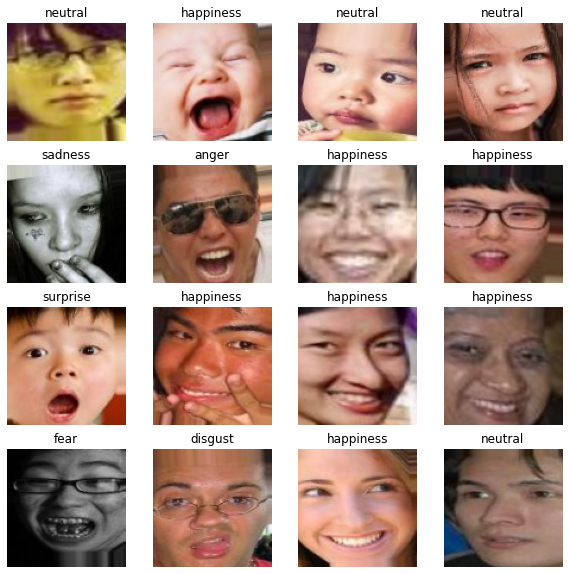

In [7]:
images, labels = next(train_ds)

plt.subplots(4,4, figsize=(10, 10))
for i in range(16):
    plt.subplot(4,4, i+1)
    plt.imshow(
        de_preprocess(images[i])
    )
    plt.title(vec2label(labels[i]))
    plt.axis('off')
plt.show()

# Model

## Base model
Architecture of the model without classification layer.

In [8]:
from utils.ModelGenerator import get_base_model2

# get base model
model = get_base_model2(IMG_SHAPE)

2022-02-02 19:39:32.293957: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Classification model
Add classification layer to the base model.

In [9]:
# add classification layer (softmax)
model.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="softmax"))

# load pretrained version if required
if pretrained_model_name is not None:
    model.load_weights(f'./models/{pretrained_model_name}')

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (ConvLayer)    (None, 100, 100, 64)      2048      
                                                                 
 block1_conv2 (ConvLayer)    (None, 100, 100, 64)      37184     
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 33, 33, 64)        0         
                                                                 
 block2_conv1 (ConvLayer)    (None, 33, 33, 96)        55776     
                                                                 
 block2_conv2 (ConvLayer)    (None, 33, 33, 96)        83424     
                                                                 
 block2_conv3 (ConvLayer)    (None, 33, 33, 96)        83424     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 11, 11, 96)        0

# Training

In [10]:
# callbacks
dt = datetime.now().strftime("%m%d-%H%M")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"./modelcheckpoints/{model_name}_{dt}",
                                       monitor='val_accuracy',
                                       save_best_only=True,
                                       verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                         factor=0.1,
                                         patience=4,
                                         verbose=1,
                                         mode='auto',
                                         min_lr=0.00000001),
    tf.keras.callbacks.CSVLogger(f'./log/{model_name}_{dt}.csv',
                                 separator=",", append=True)
]

In [13]:
%%time

epochs = 30

history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=callbacks)

Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 1.5232 - accuracy: 0.4106
Epoch 00001: val_accuracy improved from 0.01653 to 0.26033, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 79s 3s/step - loss: 1.5232 - accuracy: 0.4106 - val_loss: 11.2606 - val_accuracy: 0.2603 - lr: 0.0010
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 1.4850 - accuracy: 0.4399
Epoch 00002: val_accuracy did not improve from 0.26033
30/30 [==============================] - 65s 2s/step - loss: 1.4850 - accuracy: 0.4399 - val_loss: 3.9196 - val_accuracy: 0.0413 - lr: 0.0010
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 1.4487 - accuracy: 0.4655
Epoch 00003: val_accuracy did not improve from 0.26033
30/30 [==============================] - 70s 2s/step - loss: 1.4487 - accuracy: 0.4655 - val_loss: 4.9091 - val_accuracy: 0.2025 - lr: 0.0010
Epoch 4/30
30/30 [==============================] - ETA: 0s - loss: 1.4158 - accuracy: 0.4801
Epoch 00004: val_accuracy improved from 0.26033 to 0.33471, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 71s 2s/step - loss: 1.4158 - accuracy: 0.4801 - val_loss: 1.6530 - val_accuracy: 0.3347 - lr: 0.0010
Epoch 5/30
30/30 [==============================] - ETA: 0s - loss: 1.3726 - accuracy: 0.4984
Epoch 00005: val_accuracy improved from 0.33471 to 0.43388, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 69s 2s/step - loss: 1.3726 - accuracy: 0.4984 - val_loss: 1.7428 - val_accuracy: 0.4339 - lr: 0.0010
Epoch 6/30
30/30 [==============================] - ETA: 0s - loss: 1.3042 - accuracy: 0.5450
Epoch 00006: val_accuracy improved from 0.43388 to 0.52066, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 68s 2s/step - loss: 1.3042 - accuracy: 0.5450 - val_loss: 1.4964 - val_accuracy: 0.5207 - lr: 0.0010
Epoch 7/30
30/30 [==============================] - ETA: 0s - loss: 1.2629 - accuracy: 0.5711
Epoch 00007: val_accuracy did not improve from 0.52066
30/30 [==============================] - 64s 2s/step - loss: 1.2629 - accuracy: 0.5711 - val_loss: 1.4822 - val_accuracy: 0.4669 - lr: 0.0010
Epoch 8/30
30/30 [==============================] - ETA: 0s - loss: 1.2092 - accuracy: 0.5952
Epoch 00008: val_accuracy did not improve from 0.52066
30/30 [==============================] - 64s 2s/step - loss: 1.2092 - accuracy: 0.5952 - val_loss: 1.8269 - val_accuracy: 0.3678 - lr: 0.0010
Epoch 9/30
30/30 [==============================] - ETA: 0s - loss: 1.1735 - accuracy: 0.6109
Epoch 00009: val_accuracy did not improve from 0.52066
30/30 [==============================] - 63s 2s/step - loss: 1.1735 - accuracy: 0.6109 - val_loss: 2.4235 - val_accuracy: 0.239

INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 68s 2s/step - loss: 1.0871 - accuracy: 0.6736 - val_loss: 1.3547 - val_accuracy: 0.5620 - lr: 0.0010
Epoch 13/30
30/30 [==============================] - ETA: 0s - loss: 1.0753 - accuracy: 0.6747
Epoch 00013: val_accuracy did not improve from 0.56198
30/30 [==============================] - 64s 2s/step - loss: 1.0753 - accuracy: 0.6747 - val_loss: 1.6018 - val_accuracy: 0.5124 - lr: 0.0010
Epoch 14/30
30/30 [==============================] - ETA: 0s - loss: 1.0288 - accuracy: 0.6940
Epoch 00014: val_accuracy did not improve from 0.56198
30/30 [==============================] - 64s 2s/step - loss: 1.0288 - accuracy: 0.6940 - val_loss: 1.4050 - val_accuracy: 0.5496 - lr: 0.0010
Epoch 15/30
30/30 [==============================] - ETA: 0s - loss: 1.0283 - accuracy: 0.6935
Epoch 00015: val_accuracy improved from 0.56198 to 0.68182, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 66s 2s/step - loss: 1.0283 - accuracy: 0.6935 - val_loss: 1.1379 - val_accuracy: 0.6818 - lr: 0.0010
Epoch 16/30
30/30 [==============================] - ETA: 0s - loss: 0.9979 - accuracy: 0.7296
Epoch 00016: val_accuracy did not improve from 0.68182
30/30 [==============================] - 63s 2s/step - loss: 0.9979 - accuracy: 0.7296 - val_loss: 1.4302 - val_accuracy: 0.5496 - lr: 0.0010
Epoch 17/30
30/30 [==============================] - ETA: 0s - loss: 0.9876 - accuracy: 0.7374
Epoch 00017: val_accuracy improved from 0.68182 to 0.69008, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 66s 2s/step - loss: 0.9876 - accuracy: 0.7374 - val_loss: 1.0805 - val_accuracy: 0.6901 - lr: 0.0010
Epoch 18/30
30/30 [==============================] - ETA: 0s - loss: 0.9784 - accuracy: 0.7380
Epoch 00018: val_accuracy did not improve from 0.69008
30/30 [==============================] - 63s 2s/step - loss: 0.9784 - accuracy: 0.7380 - val_loss: 1.1382 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 19/30
30/30 [==============================] - ETA: 0s - loss: 0.9494 - accuracy: 0.7479
Epoch 00019: val_accuracy did not improve from 0.69008
30/30 [==============================] - 64s 2s/step - loss: 0.9494 - accuracy: 0.7479 - val_loss: 1.1416 - val_accuracy: 0.6612 - lr: 0.0010
Epoch 20/30
30/30 [==============================] - ETA: 0s - loss: 0.9255 - accuracy: 0.7809
Epoch 00020: val_accuracy did not improve from 0.69008
30/30 [==============================] - 63s 2s/step - loss: 0.9255 - accuracy: 0.7809 - val_loss: 1.1640 - val_accuracy: 0.

INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 66s 2s/step - loss: 0.8852 - accuracy: 0.8023 - val_loss: 1.0517 - val_accuracy: 0.7025 - lr: 1.0000e-04
Epoch 23/30
30/30 [==============================] - ETA: 0s - loss: 0.8516 - accuracy: 0.8269
Epoch 00023: val_accuracy improved from 0.70248 to 0.72727, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 67s 2s/step - loss: 0.8516 - accuracy: 0.8269 - val_loss: 1.0109 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 24/30
30/30 [==============================] - ETA: 0s - loss: 0.8354 - accuracy: 0.8353
Epoch 00024: val_accuracy did not improve from 0.72727
30/30 [==============================] - 63s 2s/step - loss: 0.8354 - accuracy: 0.8353 - val_loss: 1.0003 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 25/30
30/30 [==============================] - ETA: 0s - loss: 0.8238 - accuracy: 0.8478
Epoch 00025: val_accuracy improved from 0.72727 to 0.73140, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 66s 2s/step - loss: 0.8238 - accuracy: 0.8478 - val_loss: 0.9847 - val_accuracy: 0.7314 - lr: 1.0000e-04
Epoch 26/30
30/30 [==============================] - ETA: 0s - loss: 0.8204 - accuracy: 0.8530
Epoch 00026: val_accuracy improved from 0.73140 to 0.76033, saving model to ./modelcheckpoints/RAF-bias_0202-1939


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./modelcheckpoints/RAF-bias_0202-1939/assets


30/30 [==============================] - 67s 2s/step - loss: 0.8204 - accuracy: 0.8530 - val_loss: 0.9810 - val_accuracy: 0.7603 - lr: 1.0000e-04
Epoch 27/30
30/30 [==============================] - ETA: 0s - loss: 0.8236 - accuracy: 0.8504
Epoch 00027: val_accuracy did not improve from 0.76033
30/30 [==============================] - 64s 2s/step - loss: 0.8236 - accuracy: 0.8504 - val_loss: 0.9804 - val_accuracy: 0.7314 - lr: 1.0000e-04
Epoch 28/30
30/30 [==============================] - ETA: 0s - loss: 0.8113 - accuracy: 0.8609
Epoch 00028: val_accuracy did not improve from 0.76033
30/30 [==============================] - 59s 2s/step - loss: 0.8113 - accuracy: 0.8609 - val_loss: 0.9853 - val_accuracy: 0.7438 - lr: 1.0000e-04
Epoch 29/30
30/30 [==============================] - ETA: 0s - loss: 0.8067 - accuracy: 0.8687
Epoch 00029: val_accuracy did not improve from 0.76033
30/30 [==============================] - 52s 2s/step - loss: 0.8067 - accuracy: 0.8687 - val_loss: 0.9817 - val_

# Results

## Training Results

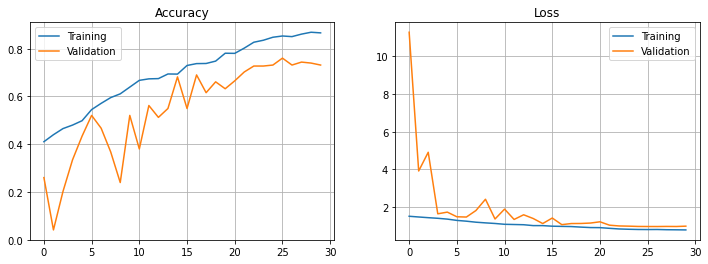

In [14]:
plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Accuracy")
plt.grid(); plt.legend()
# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.grid(); plt.legend()
plt.show()

## Test Results

In [15]:
loss, acc = model.evaluate(test_ds, verbose=2)

print("\nAccuracy:\t%.2f%%" % (acc * 100))
print("Loss:\t\t%.4f" % (loss))

4/4 - 2s - loss: 1.0063 - accuracy: 0.7635 - 2s/epoch - 409ms/step

Accuracy:	76.35%
Loss:		1.0063


# Save Model

In [16]:
if True:
    model.save_weights('./models/' + model_name + "_" + dt + '_weights.h5')
    model.save("./models/" + model_name + "_" + dt + "/")
    f = open("./models/info.txt", "a")
    txt = model_name + "_" + dt + " = " + str(np.max(history.history['val_accuracy'])*100) + "\n"
    f.write(txt)
    f.close()

INFO:tensorflow:Assets written to: ./models/RAF-bias_0202-1939/assets


INFO:tensorflow:Assets written to: ./models/RAF-bias_0202-1939/assets


---